In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("darkgrid")

In [4]:
def burrito(round,day):
    m = gp.Model('burrito')
    csv_path = "csvs/round"+round+"/day"
    demand_node_df = pd.read_csv(csv_path+day+"/round"+round+"-day"+day+"_demand_node_data.csv")
    demand_node_df = demand_node_df.set_index('index')
    truck_node_df = pd.read_csv(csv_path+day+"/round"+round+"-day"+day+"_truck_node_data.csv")
    truck_node_df.set_index('index', inplace=True)
    demand_truck_df = pd.read_csv(csv_path+day+"/round"+round+"-day"+day+"_demand_truck_data.csv")
    demand_truck_df = demand_truck_df.set_index(['truck_node_index','demand_node_index'])
    scaled_demand = [demand_truck_df['scaled_demand']][0]
    problem_df = pd.read_csv(csv_path+day+"/round"+round+"-day"+day+"_problem_data.csv")
    burrito_price = problem_df['burrito_price'][0]
    ingredient_cost = problem_df['ingredient_cost'][0]
    truck_cost = problem_df['truck_cost'][0]
    profit = burrito_price-ingredient_cost
    print("Profit: ",profit)
    print("Truck Cost: ",truck_cost)
    customers = demand_node_df.index.values
    trucks = truck_node_df.index.values
    route_choice = m.addVars(
        trucks,customers,
        vtype = GRB.BINARY,
        name = "routes_assigned"
    )

    truck_choice = m.addVars(
        trucks,
        vtype = GRB.BINARY,
        name = "trucks_assigned"
    )
    route_con = m.addConstrs(
        (gp.quicksum(
            route_choice[i,j]
            for i in trucks
        ) <=1
        for j in customers),
        name = "route_constraint"
    )

    truck_con = m.addConstrs(
        (route_choice[i,j] <= truck_choice[i]
        for i in trucks for j in customers),
        name = "truck_constraint"
    )
    m.setObjective(
        gp.quicksum(
            profit * scaled_demand[i, j] * route_choice[i, j]
            for i in trucks
            for j in customers
        ) -
        gp.quicksum(
            truck_cost * truck_choice[i]
            for i in trucks
        ), GRB.MAXIMIZE
    )
    m.setParam('OutputFlag', 0)
    m.optimize()
    obj = m.getObjective().getValue()
    print("Max revenue: ", obj)
    route_solution = pd.Series(m.getAttr('X',route_choice), name='assigned_routes', index=demand_truck_df.index)
    sol = pd.concat([demand_truck_df, route_solution], axis=1)
    pos_sol = sol[sol['assigned_routes']>0]
    print(pos_sol)

    # Create a graph
    G = nx.Graph()

    # Add nodes
    for i, row in demand_node_df.iterrows():
        G.add_node(i, pos=(row['x'], row['y']), node_type='demand')
    for i, row in truck_node_df.iterrows():
        G.add_node(i, pos=(row['x'], row['y']), node_type='truck')

    # Add edges
    for (truck, demand), row in pos_sol.iterrows():
        G.add_edge(truck, demand, weight=row['scaled_demand'])

    pos = nx.get_node_attributes(G, 'pos')
    node_colors = ['red' if G.nodes[node]['node_type'] == 'truck' and node in pos_sol.index.get_level_values('truck_node_index').unique() else 'blue' for node in G.nodes]
    edge_colors = 'gray'

    plt.figure(figsize=(10, 8))

    # Draw demand nodes in orange
    nx.draw_networkx_nodes(G, pos, nodelist=[n for n, data in G.nodes(data=True) if data['node_type'] == 'demand'], 
                           node_color='yellow', node_size=50, edgecolors='black', label='Demand Nodes')

    # Draw unassigned truck nodes in blue
    nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['node_type'] == 'truck' and n not in pos_sol.index.get_level_values('truck_node_index').unique()],
                           node_color='blue', node_size=50, edgecolors='black', label='Truck Nodes')

    # Draw assigned truck nodes in red with larger size
    nx.draw_networkx_nodes(G, pos, nodelist=pos_sol.index.get_level_values('truck_node_index').unique(),
                           node_color='red', node_size=100, edgecolors='black', label='Assigned Trucks')

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_colors)

    nx.draw_networkx_labels(G, pos, font_size=7)

    # Set reduced font size for the labels and title
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.title('Burrito Map', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)

    plt.gca().invert_yaxis()
    plt.show()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-28
Profit:  5
Truck Cost:  250
Max revenue:  1190.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck14          demand0            207.250307              5              1.0
                 demand11           169.405417             29              1.0
                 demand12           168.175392             33              1.0
                 demand15           106.834879             19              1.0
                 demand16            82.384238             45              1.0
                 demand18           163.503716             31              1.0
                 demand19           138.520754             12              1.0
                 demand20           194.769637             24              1.0
truck56          demand22           168.867020             23         

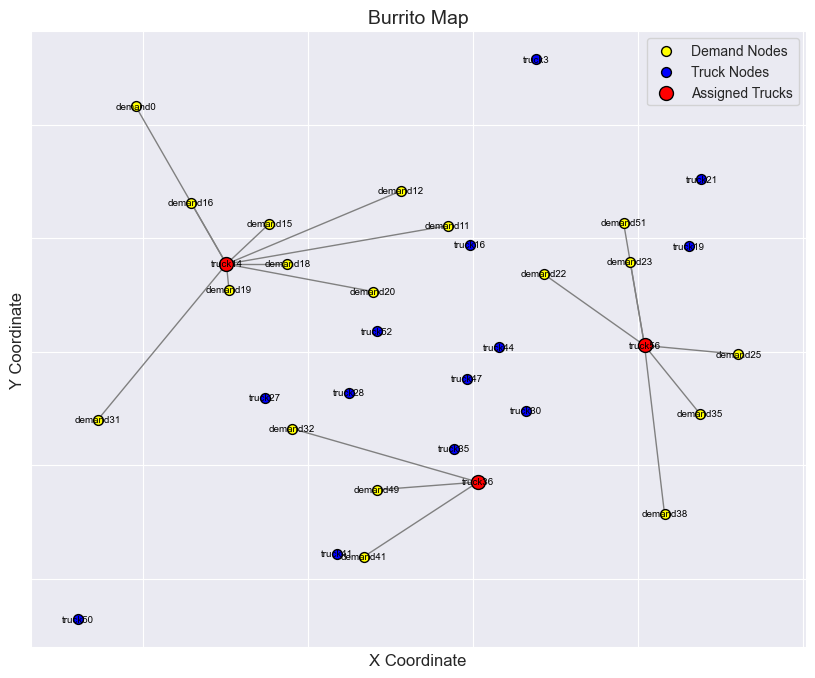

In [5]:
round = '1'
day = '1'
burrito(round,day)

Profit:  5
Truck Cost:  250
Max revenue:  5355.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck7           demand0             84.969014             70              1.0
                 demand1             81.475266             65              1.0
                 demand2            161.831991             38              1.0
truck56          demand9            160.481660             28              1.0
truck53          demand11           149.687028             11              1.0
                 demand12           148.457003             53              1.0
truck7           demand15           128.845198             13              1.0
                 demand16           158.540911             32              1.0
truck53          demand17           182.601082             35              1.0
                 demand18            75.981013             10              1.0
   

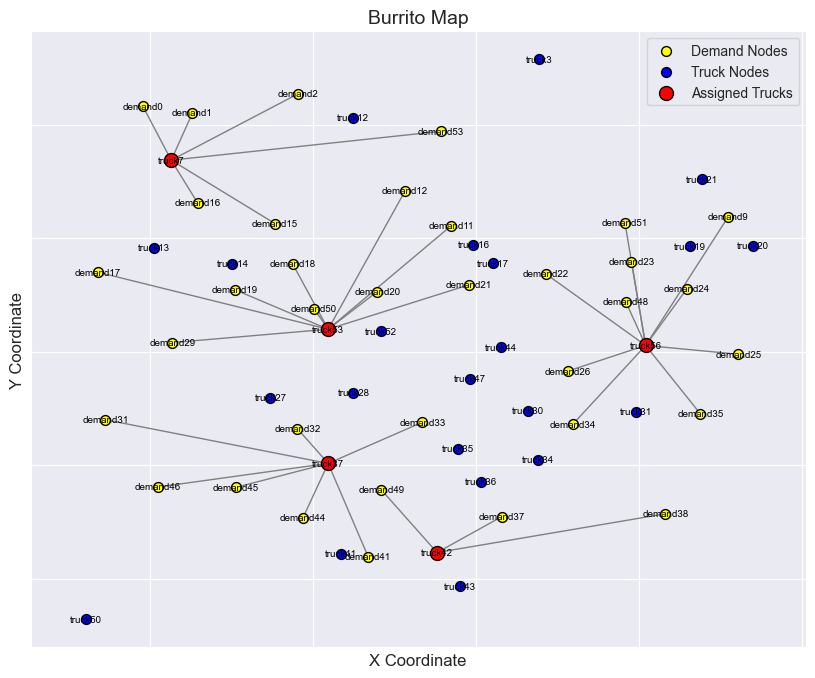

In [6]:
round = '1'
day = '2'
burrito(round,day)

Profit:  3
Truck Cost:  250
Max revenue:  2594.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck7           demand0             84.969014             65              1.0
                 demand1             81.475266             65              1.0
                 demand2            161.831991             31              1.0
truck31          demand9            201.389450             20              1.0
truck52          demand11           149.262053             41              1.0
                 demand12           177.675490             24              1.0
truck7           demand15           128.845198             64              1.0
                 demand16           158.540911             28              1.0
truck52          demand17           211.819569             33              1.0
                 demand18           105.199500             39              1.0
   

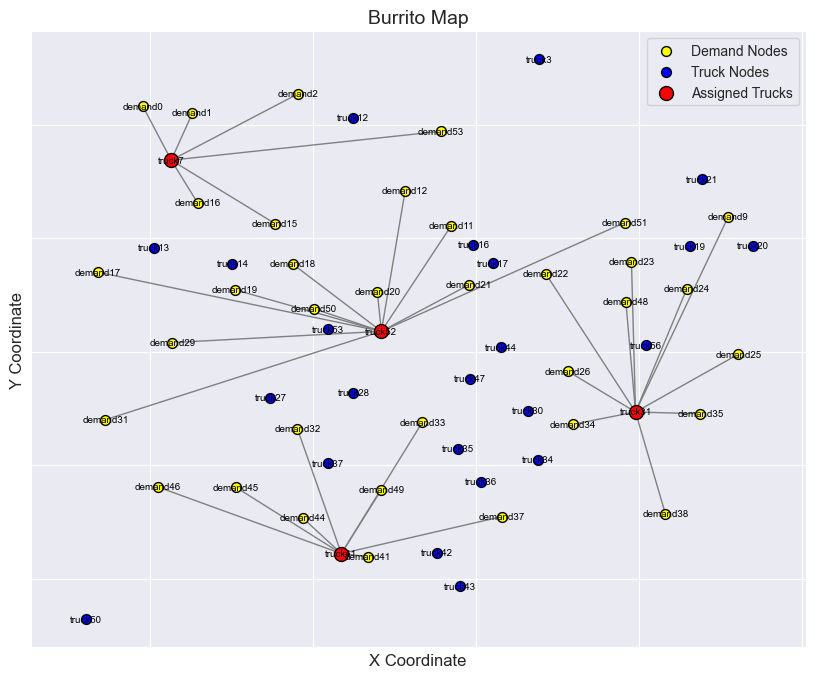

In [7]:
round = '1'
day = '3'
burrito(round,day)

Profit:  5
Truck Cost:  250
Max revenue:  1660.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck7           demand0             84.969014             65              1.0
                 demand1             81.475266             29              1.0
truck12          demand2             74.733907             50              1.0
truck20          demand9             68.226943             10              1.0
truck14          demand15           106.834879             22              1.0
                 demand16            82.384238             53              1.0
                 demand17           139.459371              2              1.0
truck52          demand18           105.199500             45              1.0
                 demand19           115.673121              7              1.0
                 demand20            62.223425             15              1.0
   

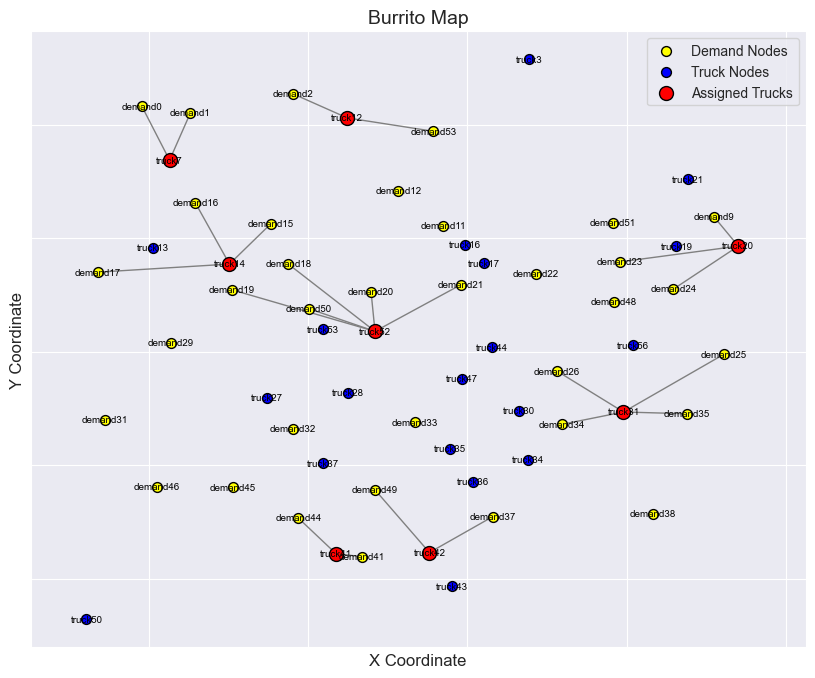

In [8]:
round = '1'
day = '4'
burrito(round,day)

Profit:  5
Truck Cost:  250
Max revenue:  6745.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck8           demand0            136.315909             33              1.0
                 demand1            132.822161             25              1.0
                 demand2            113.778542             14              1.0
truck3           demand3            111.602182             42              1.0
                 demand4             60.935664             60              1.0
                 demand5            127.613252             56              1.0
truck21          demand6             92.973314             60              1.0
                 demand7            133.631535             21              1.0
truck3           demand8             93.999876             40              1.0
truck18          demand9            134.960058             54              1.0
tru

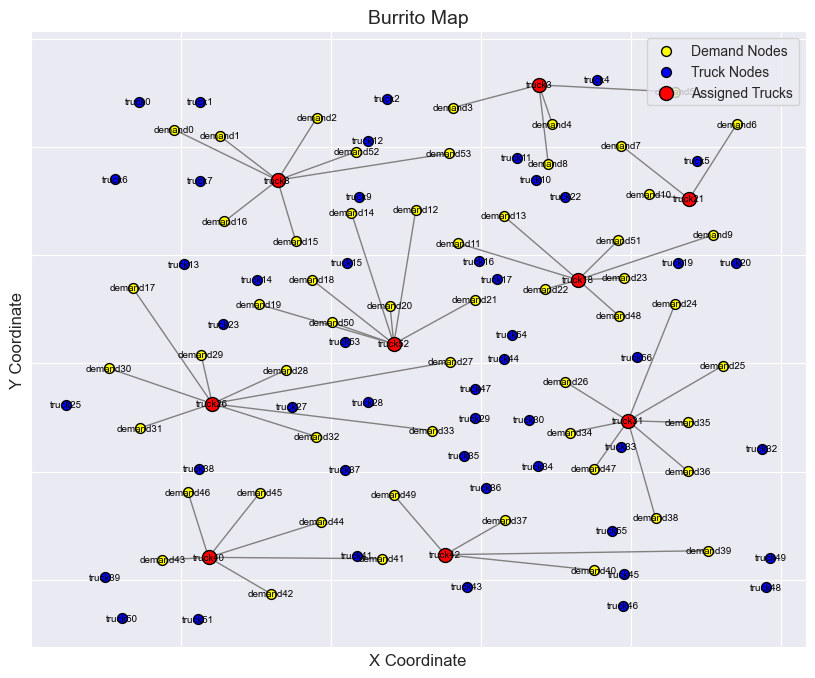

In [9]:
round = '1'
day = '5'
burrito(round,day)

Profit:  5
Truck Cost:  250
Max revenue:  1690.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck8           demand0            136.315909             23              1.0
                 demand1            132.822161             23              1.0
                 demand2            113.778542             23              1.0
                 demand11           250.435142              1              1.0
                 demand12           190.050434             13              1.0
                 demand14           195.733263              3              1.0
                 demand15            80.791749             57              1.0
truck23          demand16           142.816599             38              1.0
                 demand17           112.764612             43              1.0
                 demand18           155.247394             12              1.0
   

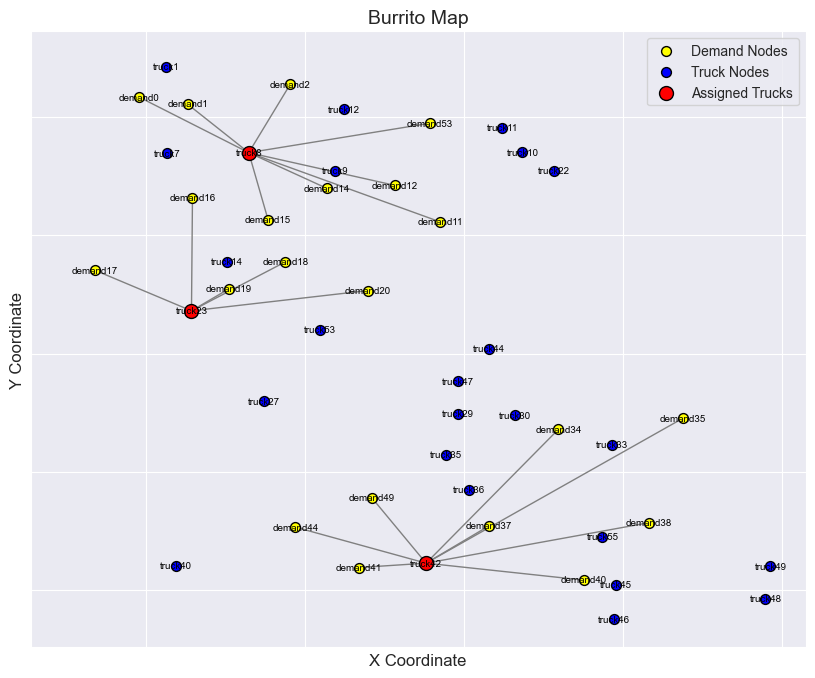

In [10]:
round = '2'
day = '1'
burrito(round,day)

Profit:  5
Truck Cost:  250
Max revenue:  1195.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck18          demand9            134.960058              6              1.0
                 demand10           188.485351             25              1.0
                 demand13           142.646522              6              1.0
                 demand20           205.684226             10              1.0
                 demand21           143.031920              6              1.0
                 demand22           118.246855              9              1.0
                 demand23           144.280945             39              1.0
truck33          demand25           134.693524             26              1.0
truck38          demand28           144.288818              5              1.0
                 demand30           207.885879             13              1.0
   

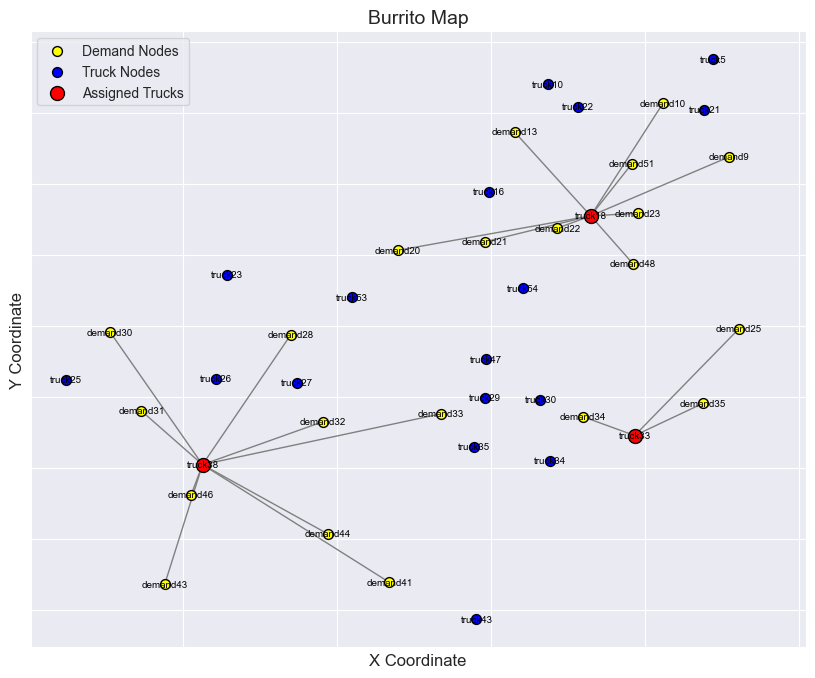

In [11]:
round = '2'
day = '2'
burrito(round,day)

Profit:  5
Truck Cost:  250
Max revenue:  2120.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck3           demand3            111.602182             41              1.0
                 demand5            127.613252             48              1.0
truck19          demand7            212.327773              6              1.0
truck3           demand8             93.999876             41              1.0
truck19          demand9             70.516388             38              1.0
                 demand10           124.041681             41              1.0
truck53          demand11           149.687028              7              1.0
                 demand14           131.567822             27              1.0
                 demand18            75.981013             20              1.0
                 demand19            86.454634             24              1.0
   

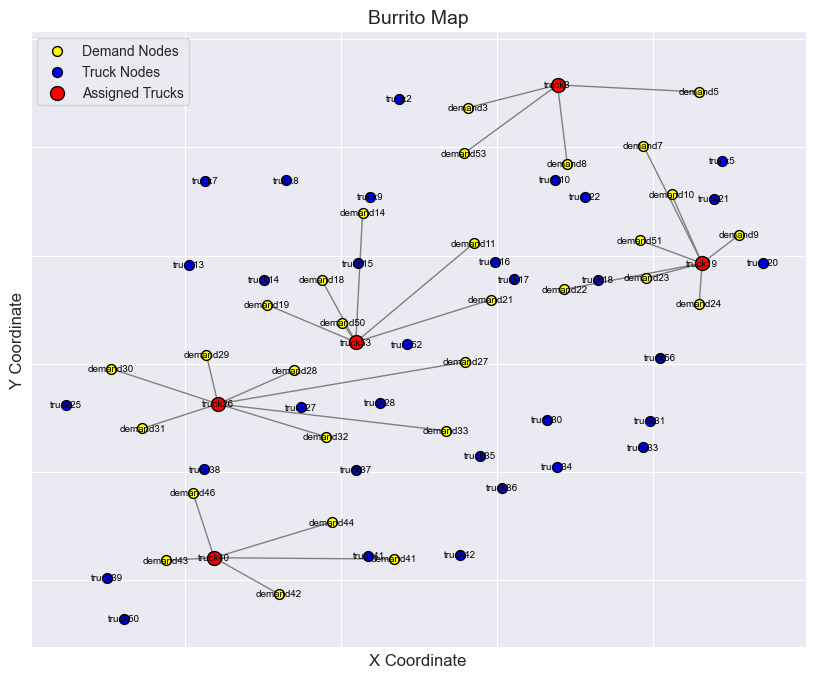

In [12]:
round = '2'
day = '3'
burrito(round,day)

Profit:  5
Truck Cost:  250
Max revenue:  790.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck15          demand2            190.359754              6              1.0
                 demand8            276.372833              1              1.0
                 demand11            96.719675             11              1.0
                 demand12            95.489650             10              1.0
                 demand13           171.087784             12              1.0
                 demand14            78.600469             20              1.0
                 demand15           183.873135              7              1.0
                 demand16           159.422494              4              1.0
                 demand17           216.497628              7              1.0
                 demand18            90.817974              6              1.0
    

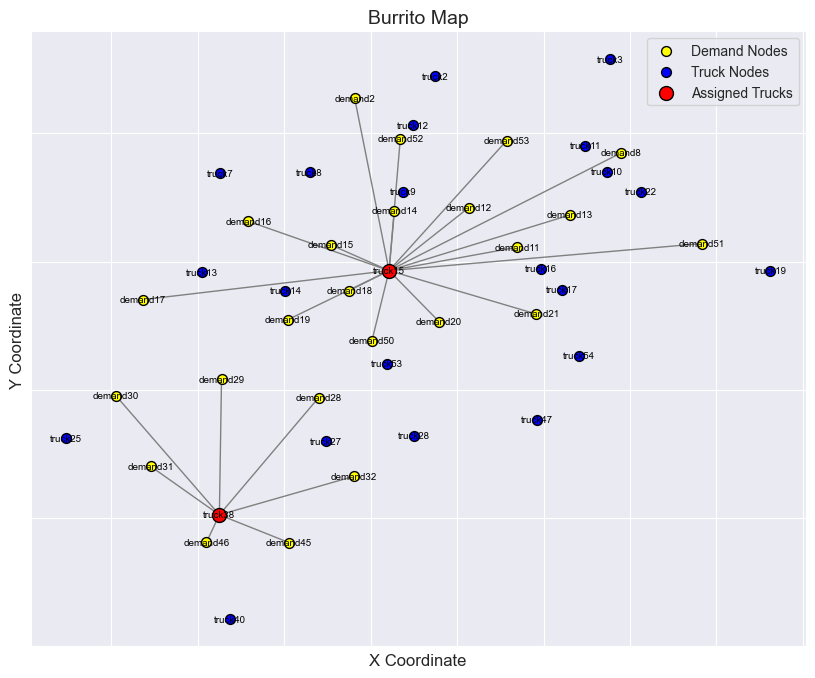

In [13]:
round = '2'
day = '4'
burrito(round,day)

Profit:  5
Truck Cost:  250
Max revenue:  7525.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck8           demand0            136.315909              5              1.0
                 demand1            132.822161             17              1.0
                 demand2            113.778542             61              1.0
truck3           demand3            111.602182             42              1.0
                 demand4             60.935664             30              1.0
                 demand5            127.613252             51              1.0
truck5           demand6             58.038363             38              1.0
                 demand7             98.696584             60              1.0
truck3           demand8             93.999876             42              1.0
truck18          demand9            134.960058              7              1.0
tru

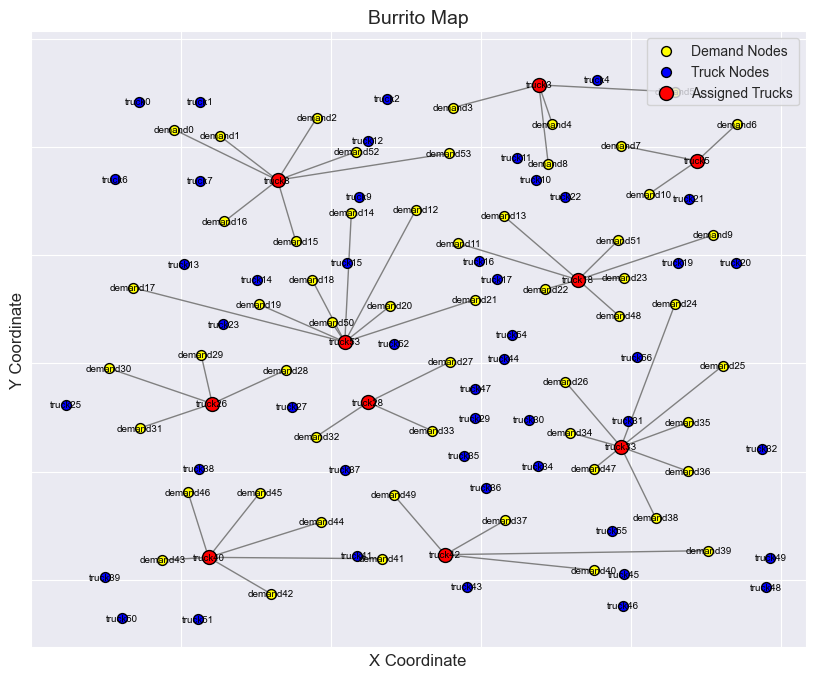

In [14]:
round = '2'
day = '5'
burrito(round,day)